## Generalised Perceptron

Multi-class classification based on MNIST and Fashion MNIST data. 

Multi-class classification problem with a configurable number of classes (up to 10). It selects them from the (Fashion-)MNIST dataset, splits it up into a train and test part, does normalisation and then trains a classifier using softmax.

Both datasets consist of images with 28x28 = 784 pixel each. The features refer to these pixel values of the images.

You can choose MNIST or Fashion-MNIST data in cell [2]

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#only at first execution data is downloaded, because it is saved in subfolder ../week1/data; 
#note the relative path to the 01.learning-optimization to avoid multiple downloads
data_set = 'FashionMNIST'
    
if data_set == 'MNIST':
    training_data = torchvision.datasets.MNIST(
        root="../01.learning-optimization/data",
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    test_data = torchvision.datasets.MNIST(
        root="../01.learning-optimization/data",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )    

    #labels for MNIST (just for compatibility reasons)
    labels_map = {
        0: "Zero",
        1: "One",
        2: "Two",
        3: "Three",
        4: "Four",
        5: "Five",
        6: "Six",
        7: "Seven",
        8: "Eight",
        9: "Nine",
    }
else:
    training_data = torchvision.datasets.FashionMNIST(
        root="../01.learning-optimization/data",
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    test_data = torchvision.datasets.FashionMNIST(
        root="../01.learning-optimization/data",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    #labels for FashionMNIST
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

In [3]:
#convert to numpy array (originally it is a torch.tensor)
x = training_data.data.numpy()
x = np.append(x, test_data.data.numpy(),0)

y = training_data.targets.numpy()
y = np.append(y, test_data.targets.numpy())

print(x.shape)
print(y.shape)

(70000, 28, 28)
(70000,)


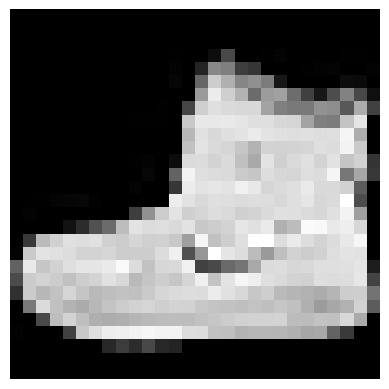

In [4]:
def plot_img(img):
    """
    plot a single mnist image
    """
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    
    
plot_img(x[0])

In [5]:
def plot_tiles(x_array, rows, cols = -1, fig_size = [10,10]):
    """
    plot list of images as single image

    Arguments:
    x_array -- array of images (being organised as ROWS!)
    rows/cols -- an image of rows x cols - images is created (if x_array is smaller zeros ared padded)
    fig_size -- size of full image created (default [10,10])
    """

    digit_size = 28 #size of digit (width = height)
    
    #use rows = cols as default
    if cols < 0:
        cols = rows
        
    if x_array.shape[0] < rows*cols:
        cols = int(x_array.shape[0]/rows)
        remain = np.mod(x_array.shape[0], rows)
        if 0 < remain:
            cols += 1
            x_array = np.append(x_array, np.zeros((rows-remain, x_array.shape[1])), 0)    
        
    img = x_array[0:rows,:].reshape(rows*digit_size,digit_size)
    for i0 in range(1,cols):
        #the reshape operator in the append call takes num of digit_size x digit_size images and 
        #puts them in a single column; append then does the rest
        img = np.append(img, x_array[i0*rows:(i0+1)*rows,:].reshape(rows*digit_size,digit_size),1)

    fig = plt.figure(figsize = fig_size)
    ax = fig.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()

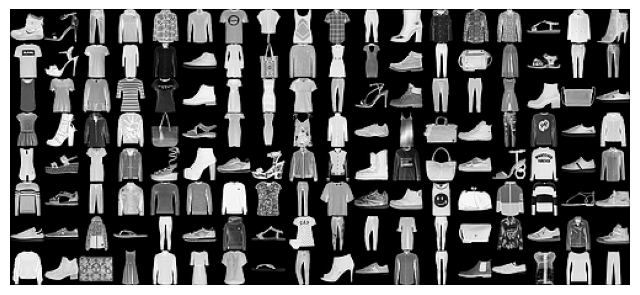

In [6]:
#append rows x cols tiles of images
rows = 8
cols = 18
#figure size can be set
fig_size = [8,8]

plot_tiles(x, rows, cols, fig_size)

T-Shirt


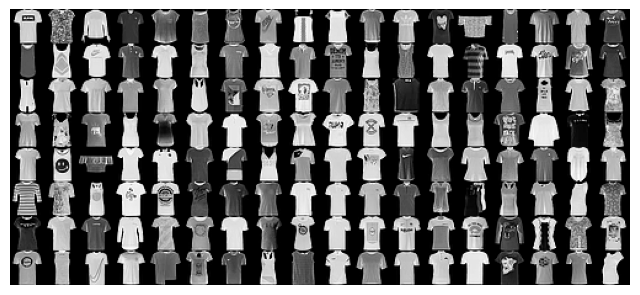

In [7]:
#choose a given class 0..9
digit  = 0

plot_tiles(x[y == digit,:], rows, cols, fig_size)
print(labels_map[digit])

In [8]:
#select the classes for your training and test set, select train and test split and to normalization
def prepare_data(classes, train_size=0.8, min_max_normalise=1, flatten=1):
    """
    prepare the data for training

    Arguments:
    classes -- list of classes to use for training (at least two classes must be given)
    train_size -- fraction of train image size
    min_max_normalise -- whether to do min-max-normalisation (1) or rescaling (0)
    flatten -- whether to flatten the 28x28 image to single row (=1); otherwise a new dimension is added at axis=1 (to be compatible with cnn)
    """
    
    for label in classes:
        print('labels chosen are: %r' % labels_map[label])

    ind_sel = np.isin(y, classes)
    x_sel = x[ind_sel,:].copy()
    y_sel = y[ind_sel].copy()

    #replace the labels such that they are in successive order
    for i0 in range(0,len(classes)):
        if i0 != classes[i0]:
            y_sel[y_sel == classes[i0]] = i0

    #we give y back as simple vector -> simplifies handling below
    #y_sel = np.reshape(y_sel, (-1,1))
    
    #do train and test split
    num_samples = x_sel.shape[0]
    max_train_ind = int(train_size*num_samples)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    x_train = x_sel[indices[:max_train_ind]]
    x_test = x_sel[indices[max_train_ind:]]
    
    y_train = y_sel[indices[:max_train_ind]]
    y_test = y_sel[indices[max_train_ind:]]

    #perform normalisation, take care of converting data type to float!
    xmax, xmin = np.max(x_train), np.min(x_train)
    
    if min_max_normalise:
        x_train = 2*(x_train.astype(float) - xmin) / (xmax - xmin) - 1
        x_test = 2*(x_test.astype(float) - xmin) / (xmax - xmin) - 1
    else:
        x_train = x_train.astype(float) / xmax 
        x_test = x_test.astype(float) / xmax 

    if flatten:
        m = x_train.shape[0]
        x_train = x_train.reshape([m,-1])
        m = x_test.shape[0]
        x_test = x_test.reshape([m,-1])
    
    return x_train, x_test, y_train, y_test

### Class MiniBatches

Splits the given dataset (`x: features` and `y: labels`) into individual batches of size `batch_size` (a value of `0` will return the full batch). The total number of batches available in an epoch is returned with method `number_of_batches()`. Each call to `next()` will return a new batch in the given format: `{'x_batch': x_batch, 'y_batch': y_batch}`

In [9]:
class MiniBatches:
    """
    split set into batches

    Arguments:
    x -- features
    y -- corresponding labels
    batch_size -- size of batches
    """
    

    def __init__(self, x, y, batch_size):
        self.x = x
        self.y = y
        m = x.shape[0]
        self.indices = np.arange(m)
        self.n = x.shape[1]
        
        if not batch_size:
            self.batch_size = m
            self.mb = 1
        else:
            self.batch_size = batch_size        
            self.mb = int(m / self.batch_size)    
            np.random.shuffle(self.indices)
        
        self.ib = 0

    def number_of_batches(self):
        return self.mb

    def next(self):
        it = self.indices[self.ib * self.batch_size:(self.ib + 1) * self.batch_size]
        x_batch = self.x[it, :]
        y_batch = self.y[it]
        self.ib += 1

        return {'x_batch': x_batch, 'y_batch': y_batch}

### Class NeuralNetwork

This class constructs a generalised perceptron. Cost function is CE. The method $propagate()$ returns the prediction $$ \hat{y}^{(i)}=h_\theta(\mathbf{x}^{(i)}) $$ on the input data (can be a n x 784 matrix of n images) and $back\_propagate()$ determines the gradients of the cost function with respect to the parameters (weights and bias) $$ \nabla_{\mathbf{\theta}} J(\mathbf{\theta}) $$
The method $gradient\_descend()$ finally does the correction of the parameters with a step in the negative gradient direction, weighted with the learning rate $$\alpha$$

In [10]:
class NeuralNetwork:
    """
    NN class handling the layers and doing all propagation and back-propagation steps
    """
    def __init__(self, size_out, random_std = 0, size_in = 784):
        """
        constructor

        Arguments:
        size_out -- number of outputs (i.e. of classes)
        random_std -- std for initialisation of weight (default is 0)
        size_in -- size of input image
        """
        self.size_out = size_out
        self.size_in = size_in        

        #initialize weights and bias (zero or random)
        self.initialise_weights(random_std)
        
        # result array for cost and error of training and validation set
        self.result_data = np.array([])
        self.result_data_dL = np.array([])
        
        #we keep a global step counter, thus that optimise can be called 
        #several times with different settings
        self.epoch_counter = 0 

        
    def initialise_weights(self, random_std):
        """
        initialize weights and bias (if random_std == 0 all weights are zero)
        """ 
        self.w = random_std*np.random.randn(self.size_in, self.size_out)
        self.b = random_std * np.random.randn(1, self.size_out)

    
    def propagate(self, x):
        """
        predicted outcome for x
        """
        ### START YOUR CODE ### 
        y_pred = np.dot(x, self.w) + self.b
        y_pred = self.activation_function(y_pred)  # Apply softmax
        ### END YOUR CODE ### 
                    
        return y_pred

    
    def activation_function(self, z):
        """
        apply activation function
        """
        ### START YOUR CODE ### softmax
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Prevent overflow
        soft_max = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        ### END YOUR CODE ### 

        return soft_max

    
    def one_hot(self, y):
        """
        construct onehot vector from set of labels
        """
        ### START YOUR CODE ### 
        m = y.shape[0]  # Number of examples
        one_hot = np.zeros((m, self.size_out))  # Create a matrix of zeros
        one_hot[np.arange(m), y] = 1  # Set the appropriate element to 1
        ### END YOUR CODE ### 

        return one_hot
    
    
    def back_propagate(self, x, y_pred, y):
        """
        calculates the gradients of cost function wrt w and b
        """
        #abbreviation
        m = x.shape[0]
        y_one_hot = self.one_hot(y)
        ### START YOUR CODE ### 
        error = y_pred - y_one_hot
        self.grad_w = np.dot(x.T, error) / m
        self.grad_b = np.sum(error, axis=0, keepdims=True) / m
        ### END YOUR CODE ### 
    
    def gradient_descend(self, alpha):
        """
        applies gradient descend step to w and b
        """
        self.w -= alpha * self.grad_w
        self.b -= alpha * self.grad_b
    
    
    def calc_error(self, y_pred, y):
        """
        get error information
        """
        m = y.shape[0]
        
        y_pred_argmax = np.argmax(y_pred, axis=1)
        error = np.sum(y != y_pred_argmax) / m

        return error
    
    
    def cost_funct(self, y_pred, y):
        """
        calculates the cost function
        """
        m = y.shape[0]
        
        #take care of possible over over or underflow
        eps=1.0e-12
        y_pred = np.clip(y_pred,eps,1-eps)
        
        ### START YOUR CODE ### 
        y = self.one_hot(y)
        cost = -np.sum(y * np.log(y_pred)) / m
        #cost = -np.sum(y * np.log(y_pred)) / m # CE
        ### END YOUR CODE ### 
                            
        return cost   
    
    
    def append_result(self):
        """
        append cost and error data to output array
        """
        # determine cost and error functions for train and validation data
        y_pred_train = self.propagate(self.data['x_train'])
        y_pred_val = self.propagate(self.data['x_val'])

        res_data = np.array([[self.cost_funct(y_pred_train, self.data['y_train']), 
                              self.calc_error(y_pred_train, self.data['y_train']),
                              self.cost_funct(y_pred_val, self.data['y_val']), 
                              self.calc_error(y_pred_val, self.data['y_val'])]])
        
        # first call
        if self.result_data.size == 0:
            self.result_data = res_data
        else:
            self.result_data = np.append(self.result_data, res_data, 0)

        #increase epoch counter here (used for plot routines below)
        self.epoch_counter += 1 
        
        return res_data
    
    
          
    def optimise(self, data, epochs, alpha, batch_size=0, debug=0):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        data -- dictionary with NORMALISED data
        epochs -- number of epochs
        alpha -- learning rate
        batch_size -- size of batches (1 = SGD, 0 = batch, 1 < .. < n = mini-batch)
        debug -- False (default)/True; get info on gradient descend step
        """
        #access to data from other methods
        self.data = data
        
        # save results before 1st step
        if self.epoch_counter == 0:
            res_data = self.append_result()

        for i0 in range(0, epochs):    
            # create batches for each epoch
            batches = MiniBatches(self.data['x_train'], self.data['y_train'], batch_size)

            for ib in range(batches.number_of_batches()):
                batch = batches.next()
            
                y_pred = self.propagate(batch['x_batch'])
                self.back_propagate(batch['x_batch'], y_pred, batch['y_batch'])
                self.gradient_descend(alpha)
          
            res_data = self.append_result()
                      
            if debug and np.mod(i0, debug) == 0:
                print('result after %d epochs, train: cost %.5f, error %.5f ; validation: cost %.5f, error %.5f'
                                          % (self.epoch_counter-1, res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3]))

        if debug:
            print('result after %d epochs, train: cost %.5f, error %.5f ; validation: cost %.5f, error %.5f'
                  % (self.epoch_counter-1, res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3]))
    

In [11]:
def plot_error(nn_instance):
    """
    analyse error as function of epochs

    Arguments:
    nn_instance -- NeuralNetwork class to plot
    """
    epochs = np.arange(nn_instance.epoch_counter)
    train_error = nn_instance.result_data[:,1]
    val_error = nn_instance.result_data[:,3]

    plt.semilogy(epochs, train_error, label="train")
    plt.semilogy(epochs, val_error, label="validation")
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 5e-3
    ymax = 5e-1
    plt.axis([0,xmax,ymin,ymax])
    plt.legend()
    plt.show() 

In [12]:
def plot_cost(nn_instance):
    """
    analyse cost as function of epochs

    Arguments:
    nn_instance -- NeuralNetwork class to plot
    """
    epochs = np.arange(nn_instance.epoch_counter)
    train_costs = nn_instance.result_data[:,0]
    val_costs = nn_instance.result_data[:,2]

    plt.semilogy(epochs, train_costs, label="train")
    plt.semilogy(epochs, val_costs, label="validation")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 5e-2
    ymax = 2
    plt.axis([0,xmax,ymin,ymax])

    plt.legend()
    plt.show() 

### Sample execution of Neural Network

The cell below shows how to use the class NeuralNetwork and how to perform the optimisation. The training and test data is given as dictionary in the call to the method $optimise()$. The classes (from 2 to 10) can be chosen via the `classes` list. This method can be called several times in a row with different arguments.

## Minibatch

labels chosen are: 'T-Shirt'
labels chosen are: 'Trouser'
labels chosen are: 'Pullover'
labels chosen are: 'Dress'
labels chosen are: 'Coat'
labels chosen are: 'Sandal'
labels chosen are: 'Shirt'
labels chosen are: 'Sneaker'
labels chosen are: 'Bag'
labels chosen are: 'Ankle Boot'
result after 1 epochs, train: cost 0.54026, error 0.17402 ; validation: cost 0.56042, error 0.17688
result after 11 epochs, train: cost 0.49303, error 0.16913 ; validation: cost 0.55605, error 0.18446
result after 21 epochs, train: cost 0.44893, error 0.14522 ; validation: cost 0.52873, error 0.16491
result after 31 epochs, train: cost 0.47689, error 0.14605 ; validation: cost 0.56460, error 0.16393
result after 41 epochs, train: cost 0.65020, error 0.20821 ; validation: cost 0.75993, error 0.22554
result after 50 epochs, train: cost 0.37270, error 0.12772 ; validation: cost 0.47791, error 0.15768


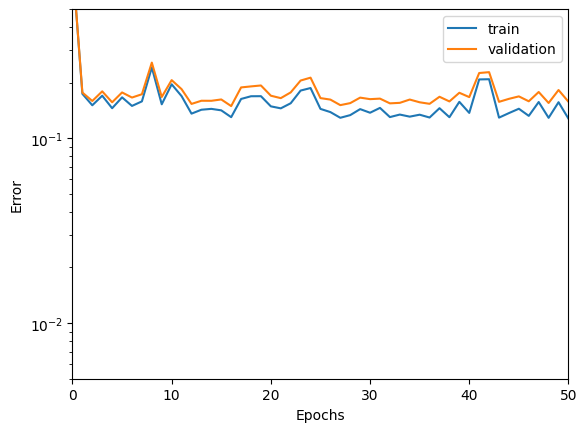

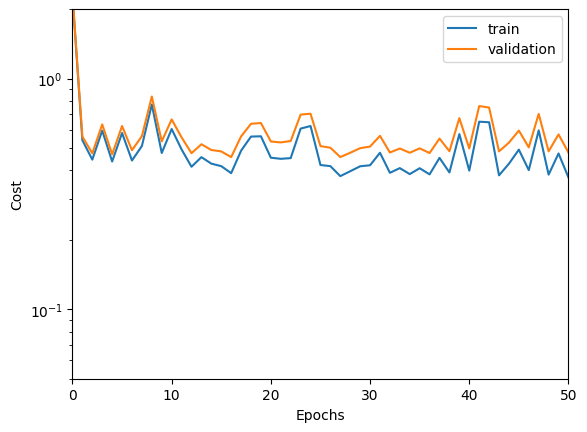

In [13]:
#choose the categories
classes = [0,1,2,3,4,5,6,7,8,9]
#classes = [1,7]
x_train, x_test, y_train, y_test = prepare_data(classes, train_size=0.8, min_max_normalise=0, flatten=1)

#further split in train and validation data
validation_size = 0.2
valid_ind = int(x_train.shape[0]*(1-validation_size))

#data is arranged as dictionary with quick access through respective keys
data = {'x_train' : x_train[:valid_ind,:], 'y_train' : y_train[:valid_ind],  \
               'x_val' : x_train[valid_ind:,:], 'y_val' : y_train[valid_ind:]}

#output size may change
size_out = len(classes)
NNet = NeuralNetwork(size_out, random_std = 0., size_in = 784)

batchsize = 64
NNet.optimise(data, 50, 0.25, batchsize, debug=10)

plot_error(NNet)
plot_cost(NNet)

# SGD

result after 1 epochs, train: cost 2.40381, error 0.18134 ; validation: cost 2.57560, error 0.19491
result after 11 epochs, train: cost 2.12193, error 0.16725 ; validation: cost 2.59453, error 0.19232
result after 20 epochs, train: cost 2.48422, error 0.16598 ; validation: cost 2.96978, error 0.18812


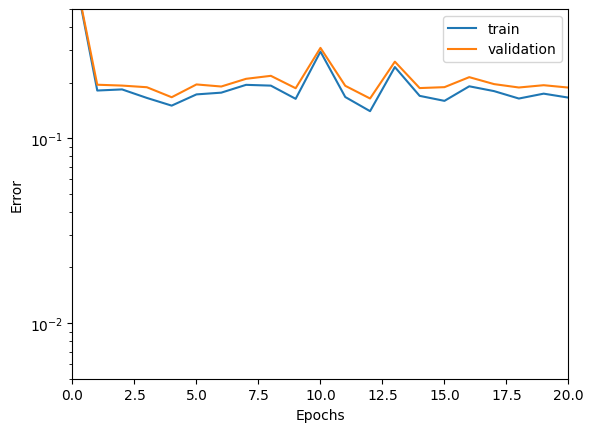

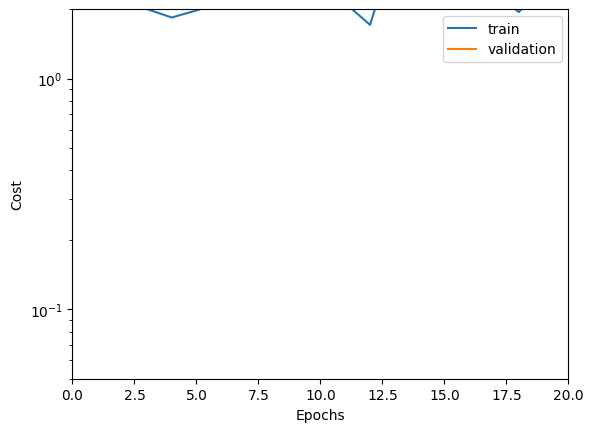

In [14]:
size_out = len(classes)
NNet = NeuralNetwork(size_out, random_std = 0., size_in = 784)

batchsize = 1
NNet.optimise(data, 20, 0.1, batchsize, debug=10)

plot_error(NNet)
plot_cost(NNet)

## BGD

result after 1 epochs, train: cost 2.17896, error 0.68004 ; validation: cost 2.17840, error 0.68536
result after 11 epochs, train: cost 1.56081, error 0.33813 ; validation: cost 1.56092, error 0.33670
result after 21 epochs, train: cost 1.29156, error 0.33395 ; validation: cost 1.29202, error 0.33286
result after 31 epochs, train: cost 1.14556, error 0.32703 ; validation: cost 1.14631, error 0.32545
result after 41 epochs, train: cost 1.05366, error 0.31641 ; validation: cost 1.05466, error 0.31312
result after 51 epochs, train: cost 0.98979, error 0.30522 ; validation: cost 0.99101, error 0.30188
result after 61 epochs, train: cost 0.94225, error 0.29165 ; validation: cost 0.94366, error 0.28937
result after 71 epochs, train: cost 0.90508, error 0.28074 ; validation: cost 0.90666, error 0.27795
result after 81 epochs, train: cost 0.87494, error 0.27147 ; validation: cost 0.87670, error 0.26804
result after 91 epochs, train: cost 0.84982, error 0.26404 ; validation: cost 0.85174, error

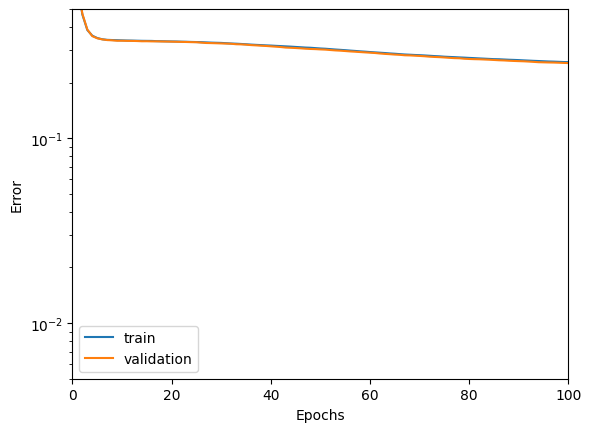

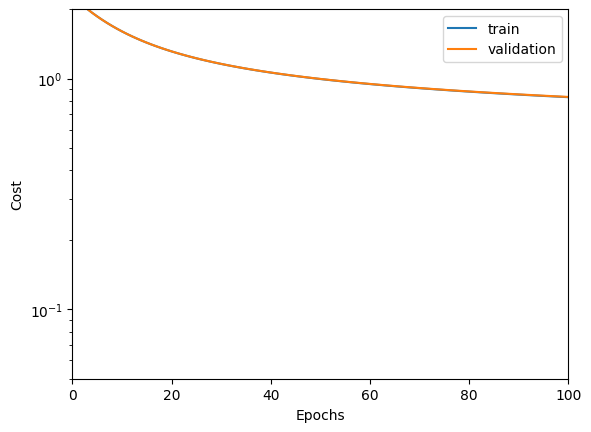

In [15]:
size_out = len(classes)
NNet = NeuralNetwork(size_out, random_std = 0., size_in = 784)

batchsize = x_train.shape[0]
NNet.optimise(data, 100, 0.05, 0, debug=10)

plot_error(NNet)
plot_cost(NNet)

### Error Rate

test error rate: 26.54 % out of 14000
(3716, 784)
[[6 4 7 5 6 5 8 6]
 [6 6 4 7 1 5 6 4]
 [5 6 0 6 4 2 2 5]
 [0 3 5 3 5 2 7 3]
 [5 9 6 2 6 6 5 2]
 [5 5 4 6 5 5 6 5]
 [6 4 6 1 5 6 6 5]]


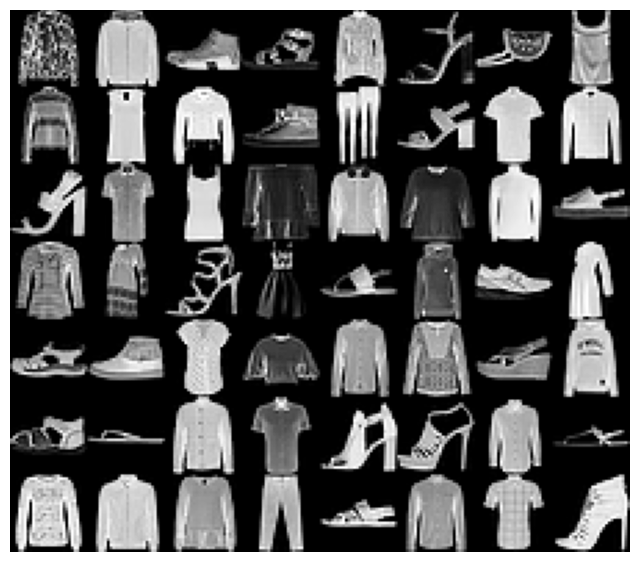

In [16]:
#analyse false classified training or test images
y_pred = np.argmax(NNet.propagate(x_test), axis=1)
false_classifications = x_test[(y_pred != y_test)]

print('test error rate: %.2f %% out of %d' % (100*false_classifications.shape[0]/y_pred.shape[0], y_pred.shape[0]))
print(false_classifications.shape)

#append rows x cols tiles of digits
rows = 7
cols = 8
#figure size can be set
fig_size = [8,8]

plot_tiles(false_classifications, rows, cols, fig_size)

#print the correct labels (for FashionMNIST)
if rows*cols < false_classifications.shape[0]:
    false_classifications_y = y_test[y_pred != y_test][:rows*cols]
else:
    false_classifications_y = np.append(y_test[y_pred != y_test], np.ones(rows*cols - false_classifications.shape[0])*-1)
print(false_classifications_y.reshape([cols,rows]).T.astype(int))

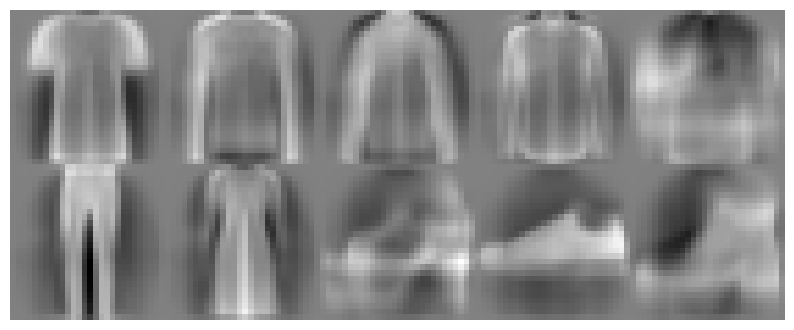

In [17]:
#visualise the weights, order is:
#0 2 4 6 8
#1 3 5 7 9 

rows = 2
cols = 5
#figure size can be set
fig_size = [10,6]

plot_tiles(NNet.w.T, rows, cols, fig_size)

# Unit Tests
### Unit Test for activation_function¶

In [18]:
#create dummy instance
size_out = 3
dummyNN = NeuralNetwork(size_out)

z_h = np.array([[0.468, 0.468, 0.063], [0.013, 0.265, 0.721], [0.211, 0.576, 0.211], [0.013, 0.265, 0.721]])

a_h = dummyNN.activation_function(z_h)

a_exp = np.array([[0.37495639, 0.37495639, 0.25008722],
               [0.23166792, 0.29806303, 0.47026905],
               [0.29065424, 0.41869151, 0.29065424],
               [0.23166792, 0.29806303, 0.47026905]])

np.testing.assert_array_almost_equal(a_h,a_exp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(a_h, axis=1), np.ones(4,dtype='float'), decimal=8)

### Unit Test for propagate 
Assumes that unit test for activation_function ist correct!

In [19]:
#create dummy instance
size_out = 3
dummyNN = NeuralNetwork(size_out)

dummyNN.w = np.array([[ 1,  0, -1],[-1,  1,  1]]).reshape(2,3)
dummyNN.b = np.array([0,0,0]).reshape(1,3)
x_h = np.array([2, 3]).reshape(1,2)
y_pred_h = dummyNN.propagate(x_h)
y_exp = np.array([0.01587624,0.86681333,0.11731043]).reshape(y_pred_h.shape)
np.testing.assert_array_almost_equal(y_pred_h,y_exp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(y_pred_h, axis=1), 1.0, decimal=8)

x_h = np.array([[ 2,  1],[-1,  1],[ 1,  1],[-1,  1]]).reshape(4,2)
y_pred_h = dummyNN.propagate(x_h)
y_exp = np.array([[0.46831053, 0.46831053, 0.06337894],
       [0.01321289, 0.26538793, 0.72139918],
       [0.21194156, 0.57611688, 0.21194156],
       [0.01321289, 0.26538793, 0.72139918]]
)
np.testing.assert_array_almost_equal(y_pred_h,y_exp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(y_pred_h, axis=1), np.ones(4,dtype='float'), decimal=8)


### Unit Test for one_hot¶

In [20]:
#create dummy instance
size_out = 4
dummyNN = NeuralNetwork(size_out)

y_h = np.array([1,3,0])
one_hot_h = dummyNN.one_hot(y_h)
one_hot_exp = np.array([[0,1,0,0],[0,0,0,1],[1,0,0,0]])
np.testing.assert_almost_equal(one_hot_h,one_hot_exp,decimal=8)

### Unit Test for back_propagate 
Assumes that unit test for propagate ist correct!

In [21]:
#create dummy instance
size_out = 3
dummyNN = NeuralNetwork(size_out)

dummyNN.w = np.array([[ 1,  0, -1],[-1,  1,  1]]).reshape(2,3)
dummyNN.b = np.array([0,0,0]).reshape(1,3)

x_h = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4).T
y_h = np.array([1,1,1,1])
y_pred_h = dummyNN.propagate(x_h)

dummyNN.back_propagate(x_h, y_pred_h, y_h)

grad_w_exp = np.array([[ 0.28053421, -0.00450948, -0.27602473],
                       [ 0.17666947, -0.60619918,  0.42952972]])
grad_b_exp = np.array([[0.17666947,-0.60619918,0.42952972]])
np.testing.assert_array_almost_equal(dummyNN.grad_w,grad_w_exp,decimal=8)
np.testing.assert_array_almost_equal(dummyNN.grad_b,grad_b_exp, decimal=8)

### Unit Test for cost_function

In [22]:
#create dummy instance
size_out = 2
dummyNN = NeuralNetwork(size_out)

y_h = np.array([1])
y_pred_h = np.array([0.04742587,0.95257413]).reshape(1,2)
cost_h = dummyNN.cost_funct(y_pred_h, y_h)
cost_exp = 0.04858735
np.testing.assert_almost_equal(cost_h,cost_exp,decimal=8)

y_h = np.array([1,1,1,0])
y_pred_h = np.array([[1.79862100e-02, 6.69285092e-03, 4.74258732e-02, 9.99088949e-01],
                  [9.82013790e-01, 9.93307149e-01, 9.52574127e-01, 9.11051194e-04]]).T
cost_h = dummyNN.cost_funct(y_pred_h, y_h)
cost_exp = 0.01859102
np.testing.assert_almost_equal(cost_h,cost_exp,decimal=8)